Exercises RNNs
==============



## Acknowledgment and Overview



This exercise is based on the Pytorch Tutorial

[https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

We will first got trough it, and then explore the issue of **exploding gradients**
with it. Finally, you should implement gradient clipping.



## Introduction



Our **goal** is to build and train a basic **character-level RNN** to classify words.
A character-level RNN reads words as a series of characters - outputting a prediction and “hidden state” at each step, feeding its previous hidden state into each next step.
We take the final prediction to be the output, i.e. which class the word belongs to.
Specifically, we’ll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling. This is an instance of a **many-to-one** model.

Preprocessing for NLP (Natural Language Processing) modeling  is done “from scratch”.
In particular we are not  using many of the convenience functions of `torchtext`.



## Prepare Data



Download the data from
[https://download.pytorch.org/tutorial/data.zip](https://download.pytorch.org/tutorial/data.zip)
Extract the data in the current directory.

Included in the data/names directory are 18 text files named as “[Language].txt”. Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We’ll end up with a dictionary of lists of names per language, {language: [names &#x2026;]}. The generic variables “category” and “line” (for language and name in our case) are used for later extensibility.



In [23]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

folderpath = 'data/08_data/names/*.txt'

def findFiles(path): return glob.glob(path)
# def findFiles(path): return [os.path.join(path, file) for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))]

print("Files found:")
print(findFiles(folderpath))
# print('\n'.join(findFiles(folderpath)))


import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(folderpath):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print(f"Number Categories: {n_categories}")
print(category_lines['German'][:10])

Files found:
['data/08_data/names/English.txt', 'data/08_data/names/Spanish.txt', 'data/08_data/names/Russian.txt', 'data/08_data/names/Chinese.txt', 'data/08_data/names/Greek.txt', 'data/08_data/names/Czech.txt', 'data/08_data/names/Scottish.txt', 'data/08_data/names/Arabic.txt', 'data/08_data/names/Korean.txt', 'data/08_data/names/Polish.txt', 'data/08_data/names/German.txt', 'data/08_data/names/Dutch.txt', 'data/08_data/names/Irish.txt', 'data/08_data/names/Italian.txt', 'data/08_data/names/Vietnamese.txt', 'data/08_data/names/Portuguese.txt', 'data/08_data/names/Japanese.txt', 'data/08_data/names/French.txt']
Number Categories: 18
['Abbing', 'Abel', 'Abeln', 'Abt', 'Achilles', 'Achterberg', 'Acker', 'Ackermann', 'Adam', 'Adenauer']


To represent a single letter, we use a **one-hot vector** of size $1 \times n_{letters}$. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 &#x2026;>.

To make a word we join a bunch of those into a 2D matrix $line_{length} \times  1 \times  n_{letters}$.

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.



In [24]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(all_letters)
print(letterToTensor('J'))
print(lineToTensor('Jones').size())

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## RNN



The architecture of this  RNN is shown in Figure [2](#orgf301017). The input and the hidden state are concatenated and
are used as the input for two feed-forward networks. One maps to the (new) hidden state, and one to
the output. The latter is passed through a soft-max layer.

![img](assets/rnn_ex.png "Architecture of model")



In [25]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

input = lineToTensor('Steffen')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8628, -2.9715, -2.9374, -2.7993, -2.8565, -2.8938, -2.8098, -2.8815,
         -2.8904, -2.9688, -2.8316, -2.9547, -3.0261, -2.7929, -2.9331, -2.8604,
         -2.8719, -2.9193]], grad_fn=<LogSoftmaxBackward0>)


## Training



Before going into training we should make a few helper functions. The first is to interpret the output of the network,
which we know to be a likelihood of each category. We can use `Tensor.topk` to get the index of the greatest value:



In [26]:
input = lineToTensor('Mayer')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden) # use input tensor 0 ('M')
print(output)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

tensor([[-2.9925, -2.8462, -2.9565, -2.8230, -2.9025, -2.9555, -2.8424, -2.8870,
         -2.8395, -2.9680, -2.8635, -2.8791, -2.9322, -2.8245, -2.9177, -2.8892,
         -2.8050, -2.9288]], grad_fn=<LogSoftmaxBackward0>)
('Japanese', 16)


A quick way to get a training example (a name and its language):



In [27]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Italian / line = Fava
category = Japanese / line = Niijima
category = Irish / line = Riagain
category = Dutch / line = Snyders
category = Japanese / line = Hirasi
category = Spanish / line = Travieso
category = Dutch / line = Lauwers
category = Scottish / line = Aitken
category = Scottish / line = Mckay
category = Japanese / line = Ooka


Each loop of training will:

-   Create input and target tensors
-   Create a zeroed initial hidden state
-   Read each letter in and
-   Keep hidden state for next letter
-   Compare final output to target
-   Back-propagate
-   Return the output and loss



In [28]:
#n_hidden = 128
#rnn = RNN(n_letters, n_hidden, n_categories)
criterion = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()

In [29]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [30]:
current_loss = 0
all_losses = []

start = time.time()

if True:
    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output, loss = train(category_tensor, line_tensor)
        current_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

    torch.save(rnn, 'data/08_data/08_char-rnn-classification.pt')

5000 5% (0m 3s) 2.1888 Babakov / Greek ✗ (Russian)
10000 10% (0m 6s) 1.8592 Montanari / Japanese ✗ (Italian)
15000 15% (0m 9s) 2.2037 Pavot / Scottish ✗ (English)
20000 20% (0m 12s) 1.2854 Szwedko / Polish ✓
25000 25% (0m 15s) 2.3335 Melo / Spanish ✗ (Portuguese)
30000 30% (0m 18s) 1.6226 Venn / Chinese ✗ (Dutch)
35000 35% (0m 21s) 0.2005 Jaskolski / Polish ✓
40000 40% (0m 24s) 3.8571 Salazar / Czech ✗ (Spanish)
45000 45% (0m 27s) 0.6017 Ang / Chinese ✓
50000 50% (0m 30s) 1.6205 Slepica / Italian ✗ (Czech)
55000 55% (0m 33s) 3.3585 Tsyurupa / Japanese ✗ (Russian)
60000 60% (0m 36s) 0.2648 Dang / Vietnamese ✓
65000 65% (0m 39s) 1.0803 Arian / Irish ✗ (Arabic)
70000 70% (0m 42s) 0.1953 Hishida / Japanese ✓
75000 75% (0m 45s) 0.7908 Bobienski / Polish ✓
80000 80% (0m 48s) 0.4629 Sook / Korean ✓
85000 85% (0m 51s) 2.5291 Rafferty / Dutch ✗ (English)
90000 90% (0m 54s) 0.3435 Crespo / Portuguese ✓
95000 95% (0m 57s) 2.2107 Kaluza / Arabic ✗ (Polish)
100000 100% (1m 0s) 4.7696 Gwock / Polish

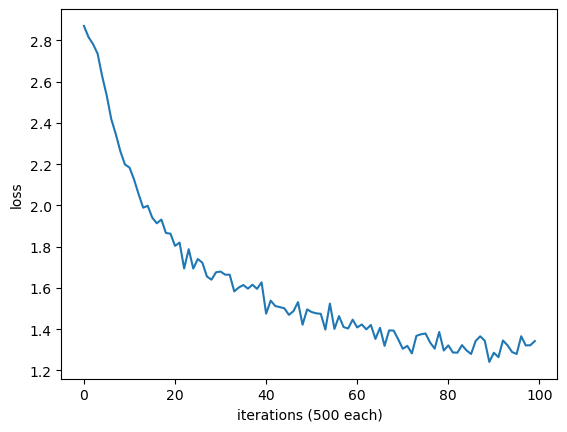

In [31]:
plt.plot(all_losses)
plt.ylabel("loss")
plt.xlabel("iterations (500 each)")
plt.show()

## Evaluation



You may want to load the rnn.



In [32]:
rnn = torch.load('data/08_data/08_char-rnn-classification.pt')

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.



/tmp/ipykernel_22203/1613978692.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_22203/1613978692.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


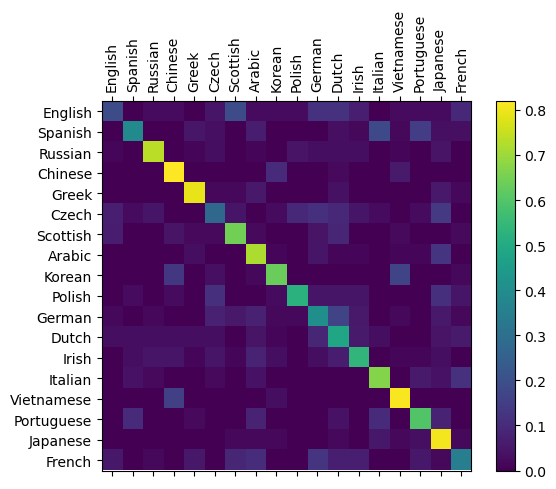

In [33]:
# Just return an output given a line
def evaluate(rnn, line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output


# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 1000

# Go through a bunch of examples and record which are correctly guessed

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(rnn, line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

For example Spanish is close to Portuguese or Italian .



## Running on user input



In [34]:
rnn = torch.load('data/08_data/08_char-rnn-classification.pt')

def predict(rnn, input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(rnn, lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict(rnn, 'Mc Ruder')
predict(rnn, 'Klinsmann')
predict(rnn, 'Mayer')


> Mc Ruder
(-0.87) Scottish
(-1.50) German
(-1.77) Dutch

> Klinsmann
(-0.13) Scottish
(-3.24) German
(-3.50) Dutch

> Mayer
(-1.46) German
(-1.75) French
(-2.21) Arabic


## TASK: Exploding Gradient



The choice of the learning rate is critical.
As mentioned, choosing it too large can lead to an **exploding** gradient.
Increase the learning rate to $0.05$ and monitor the gradient norm.
You have to override the `train` function and use the following function



In [35]:
def compute_gradient_norm(parameters, norm_type=2):
    return torch.norm(
        torch.stack([torch.norm(p.grad.detach(), norm_type) for p in parameters]), norm_type)

In [36]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
criterion = nn.NLLLoss()

learning_rate = 0.05
clipping_value = 1
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # clip gradient
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=clipping_value)

    optimizer.step()

    return output, loss.item()

In [37]:
import time
import math

n_iters = 25000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [38]:
current_loss = 0
all_losses = []
all_gradient_norms = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        gradient_norm = compute_gradient_norm(rnn.parameters())
        all_gradient_norms.append(gradient_norm)
        print(f'Gradient Norm: {gradient_norm}')

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

torch.save(rnn, 'data/08_data/08_char-rnn-classification_2.pt')

5000 20% (0m 3s) 0.0172 Antonopoulos / Greek ✓
Gradient Norm: 0.4290223717689514
10000 40% (0m 7s) 0.1747 Bao / Chinese ✓
Gradient Norm: 0.9999990463256836
15000 60% (0m 11s) 1.2504 Lovett / English ✓
Gradient Norm: 0.9999998211860657
20000 80% (0m 14s) 1.4690 Stevenson / English ✗ (Scottish)
Gradient Norm: 0.9999998211860657
25000 100% (0m 18s) 0.0002 Takizawa / Japanese ✓
Gradient Norm: 0.008242331445217133


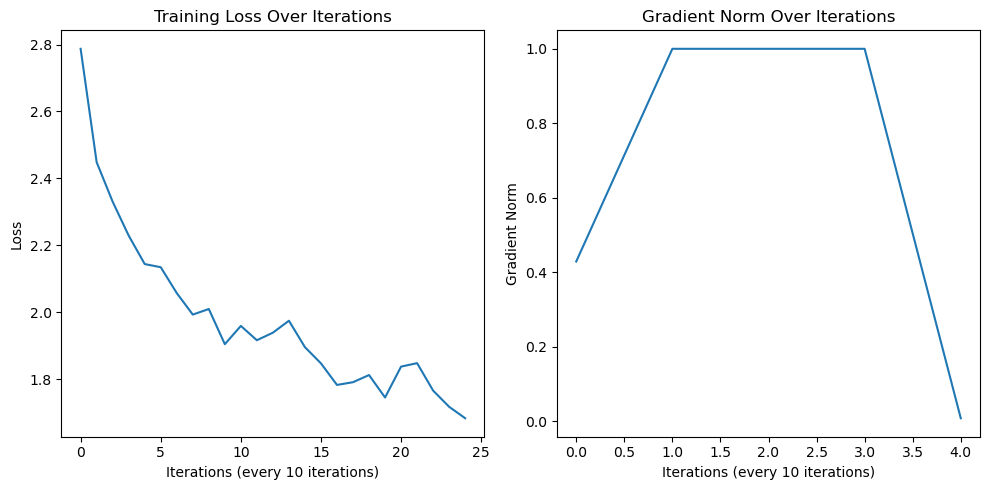

In [39]:
# Plot both training loss and gradient norms
plt.figure(figsize=(10, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(all_losses)
plt.ylabel("Loss")
plt.xlabel("Iterations (every 10 iterations)")
plt.title("Training Loss Over Iterations")

# Plot gradient norms
plt.subplot(1, 2, 2)
plt.plot(all_gradient_norms)
plt.ylabel("Gradient Norm")
plt.xlabel("Iterations (every 10 iterations)")
plt.title("Gradient Norm Over Iterations")

plt.tight_layout()
plt.show()

To see the effect run it 25000 iterations and plot the gradient norm. What happens to your loss?

To solve the issue, use **gradient clipping**, that is we simply truncate the gradient Norm
at a certain value (below we use one). See 8.5.5 of *Dive into Deep Learning* to
read more about that topic: [https://d2l.djl.ai/chapter_recurrent-neural-networks/rnn-scratch.html](https://d2l.djl.ai/chapter_recurrent-neural-networks/rnn-scratch.html).

Here is a code snippet to clip the gradient to `clipping_value`:



In [40]:
clipping_value = 1
torch.nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=clipping_value)

tensor(0.0082)

## Optional Task



Refactor the RNN to use the standard PyTorch layer `nn.RNN` as it was used in the lecture!



In [55]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        # Use nn.RNN instead of manually defining the RNN cell
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.rnn(input, hidden)
        output = self.fc(output[:, -1, :])  # Get the output from the last time step
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, batch_size):
        # Ensure the initial hidden state is 2-D
        return torch.zeros(1, self.hidden_size)
    
# class RNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(RNN, self).__init__()

#         self.hidden_size = hidden_size

#         self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
#         self.i2o = nn.Linear(input_size + hidden_size, output_size)
#         self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, input, hidden):
#         combined = torch.cat((input, hidden), 1)
#         hidden = self.i2h(combined)
#         output = self.i2o(combined)
#         output = self.softmax(output)
#         return output, hidden

#     def initHidden(self):
#         return torch.zeros(1, self.hidden_size)

In [56]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
os.environ["WORLD_SIZE"] = "1"
print(f"CUDA_VISIBLE_DEVICES: {os.getenv('CUDA_VISIBLE_DEVICES')}")
print(f"WORLD_SIZE {os.getenv('WORLD_SIZE')}")
print(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

import torch

try:
    # Check if CUDA is available
    if torch.cuda.is_available():
        # Get the number of available GPUs
        num_gpus = torch.cuda.device_count()
        print(f"Cuda GPUs: {num_gpus}")

        # List the available devices
        for i in range(num_gpus):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("No CUDA-enabled GPUs found.")
except Exception as e:
    print(f"An error occurred: {e}")

CUDA_VISIBLE_DEVICES: 1
WORLD_SIZE 1
cuda
Cuda GPUs: 1
GPU 0: NVIDIA GeForce RTX 2070 SUPER


In [60]:
n_hidden = 128
device = "cpu"
rnn = RNN(n_letters, n_hidden, n_categories)
if torch.cuda.is_available():
    rnn = rnn.to(device)
criterion = nn.NLLLoss()

learning_rate = 0.05
clipping_value = 1
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden(line_tensor.size(1))

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # clip gradient
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=clipping_value)

    optimizer.step()

    return output, loss.item()

import time
import math

n_iters = 25000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

current_loss = 0
all_losses = []
all_gradient_norms = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    
    if torch.cuda.is_available():
        line_tensor = line_tensor.to(device)
        category_tensor = category_tensor.to(device)

    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        gradient_norm = compute_gradient_norm(rnn.parameters())
        all_gradient_norms.append(gradient_norm)
        print(f'Gradient Norm: {gradient_norm}')

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

torch.save(rnn, 'data/08_data/08_char-rnn-classification_refactor.pt')

IndexError: too many indices for tensor of dimension 2